# My first chemistry autoencoder

### Imports

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import os
import pandas as pd
import sys

import torch
import torch.nn          as nn
from torch.utils.data    import Dataset, DataLoader
from torch.optim         import Adam

from matplotlib          import rcParams, rc
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 150


## import own functions
sys.path.insert(1, '/lhome/silkem/MACE/MACE/src/mace')
import autoencoder  as ae
import dataset      as ds
import plotting     as pl
import training     as tr

In [2]:
specs_file = '/lhome/silkem/CHEM/src-IP-AP-HNR/specs/rate16_IP_6000K_Crich_mean_Htot.specs'

idxs, mols = np.loadtxt(specs_file, usecols=(0,1), unpack = True, max_rows=466, skiprows=1, dtype='str')

molecs = dict()
for i in range(len(idxs)):
    molecs[mols[i]] = int(idxs[i])-1

### Model hyperparameters

In [3]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

## Set up architecture hyperparams
input_dim  = 468    #train.df.shape[1]
hidden_dim = 300
latent_dim = 10
output_dim = input_dim
nb_hidden = 2
type = 'decr'

In [4]:
## Build model

encoder = ae.Encoder( input_dim, hidden_dim, latent_dim, nb_hidden=nb_hidden, type = type)
encoder.set_name('Encoder')
decoder = ae.Decoder(latent_dim, hidden_dim, output_dim, nb_hidden=nb_hidden, type = type)
decoder.set_name('Decoder')
model = ae.Autoencoder(Encoder=encoder, Decoder=decoder).to(DEVICE)        # GPU/TPU/... --> XPU


In [5]:
ae.print_overview(encoder)
ae.print_overview(decoder)

Encoder:
       # | nodes | parameters
-----------------------------------
   input |   468 |     140700
  hidden |   300 |      45150
  hidden |   150 |      11325
  hidden |    75 |        760
  output |    10 |          /
-----------------------------------
         |       |     197935
Decoder:
       # | nodes | parameters
-----------------------------------
   input |    10 |        825
  hidden |    75 |      11400
  hidden |   150 |      45300
  hidden |   300 |     140868
  output |   468 |          /
-----------------------------------
         |       |     198393


### Data: train & test

In [6]:
dir = '/lhome/silkem/MACE/MACE/train_data_C/'

In [7]:
## Make PyTorch dataset
train = ds.MyDataset(dir=dir, scale = "norm")
test  = ds.MyDataset(dir=dir, scale = "norm", train = False)
 
print('total # of samples:',len(train)+len(test))
print('# training samples:',len(train))
print('# testing samples: ',len(test) )
print('            ratio: ',np.round(len(test)/(len(train)+len(test)),2))


total # of samples: 2187
# training samples: 1530
# testing samples:  657
            ratio:  0.3


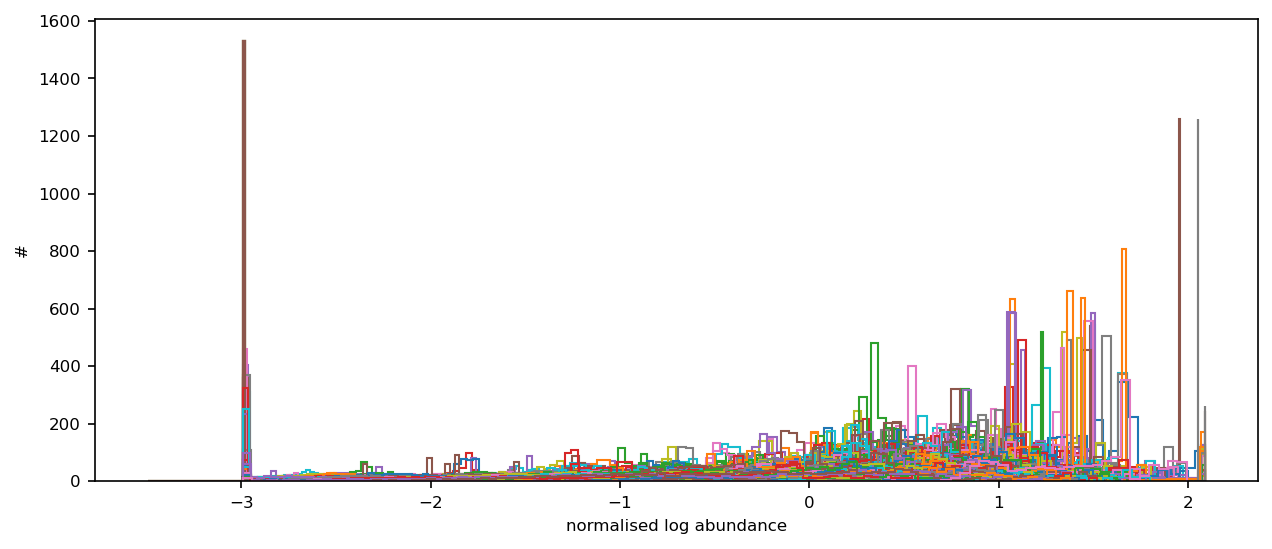

In [8]:
pl.plot_hist(train.df)

### Training

In [8]:
## Set up training hyperparams
batch_size = 100
lr = 1e-3                   ## learning rate
epochs = 20

In [9]:
## Make PyTorch tensor objects from the data set to train

kwargs = {'num_workers': 1, 'pin_memory': True} 

data_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True ,  **kwargs)
test_loader = DataLoader(dataset=test , batch_size=len(test) , shuffle=False,  **kwargs)


In [10]:
## Training & validating model

optimizer = Adam(model.parameters(), lr=lr)

loss_train_all = []
loss_test_all  = []

for epoch in range(epochs):

    ## Training
    model.train()

    train_loss = tr.train_one_epoch(data_loader, model, DEVICE, optimizer)
    loss_train_all.append(train_loss)  ## save losses

    ## Validating
    model.eval() ## zelfde als torch.no_grad

    test_loss = tr.validate_one_epoch(test_loader, model, DEVICE, optimizer)
    loss_test_all.append(test_loss)
    
    print("\tEpoch", epoch + 1, "complete!", "\tAverage loss train: ", train_loss, "\tAverage loss test: ", test_loss, end="\r")
print('\nDONE!')

	Epoch 20 complete! 	Average loss train:  0.019425515667535365 	Average loss test:  0.017245955765247345
DONE!


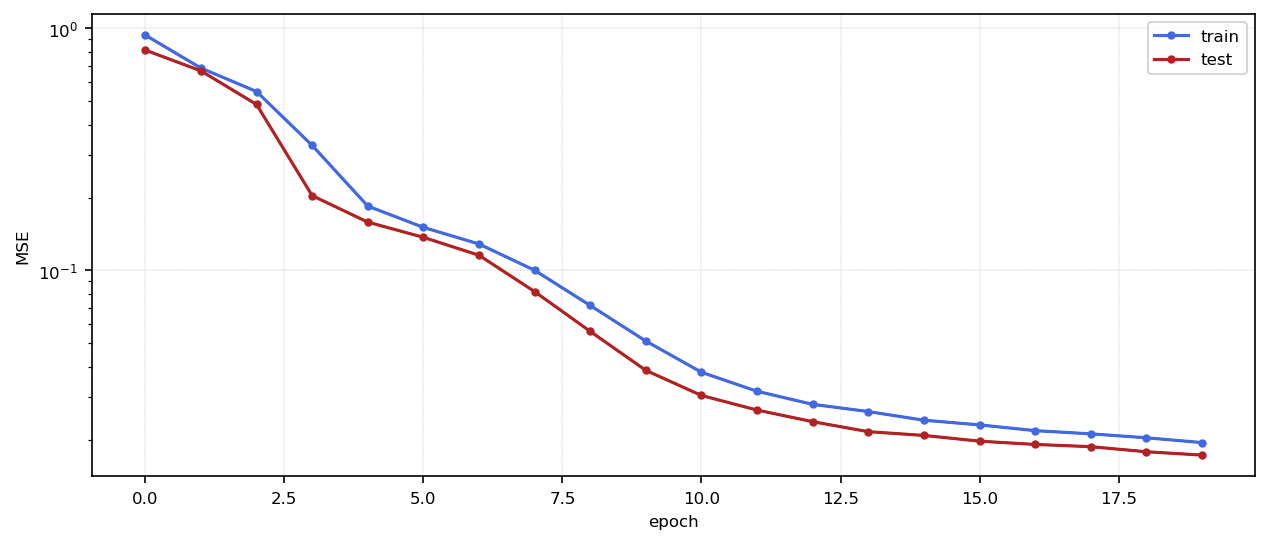

In [11]:
pl.plot_loss(loss_train_all, loss_test_all)

In [12]:
## Testing model

overall_loss = 0

with torch.no_grad():
    for i, x in enumerate(test_loader):

        x_test     = x.to(DEVICE)     ## op een niet-CPU berekenen als dat er is op de device

        x_test_hat = model(x)         ## output van het autoecoder model

        ## Calculate losses
        loss  = tr.loss_function(x_test,x_test_hat)
        overall_loss += loss.item()

print('loss:',(overall_loss)/(i+1))
        

loss: 0.017245955765247345


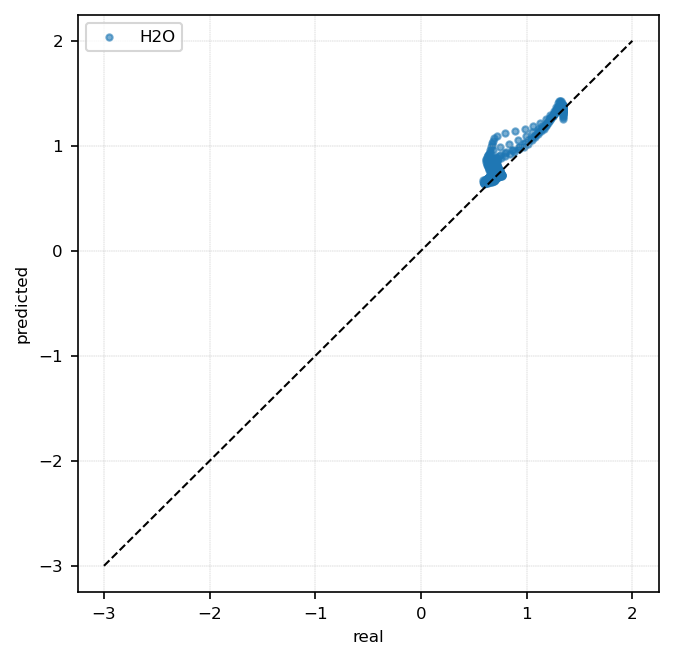

In [13]:
pl.plot_compare(x_test,x_test_hat, molecs, ['H2O'])


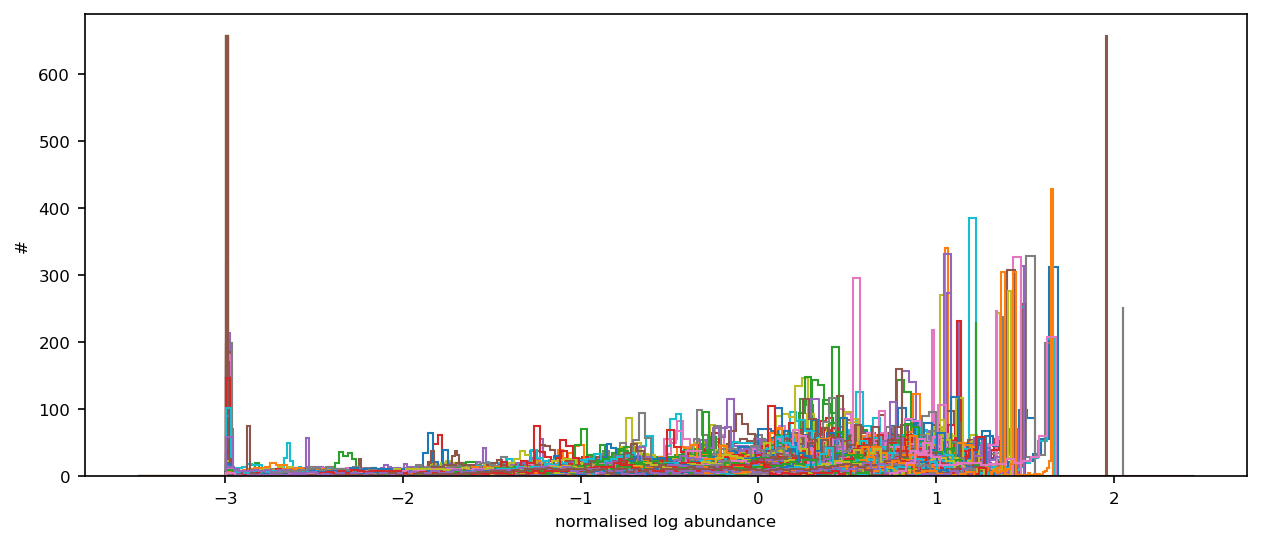

In [14]:
pl.plot_hist(x_test)

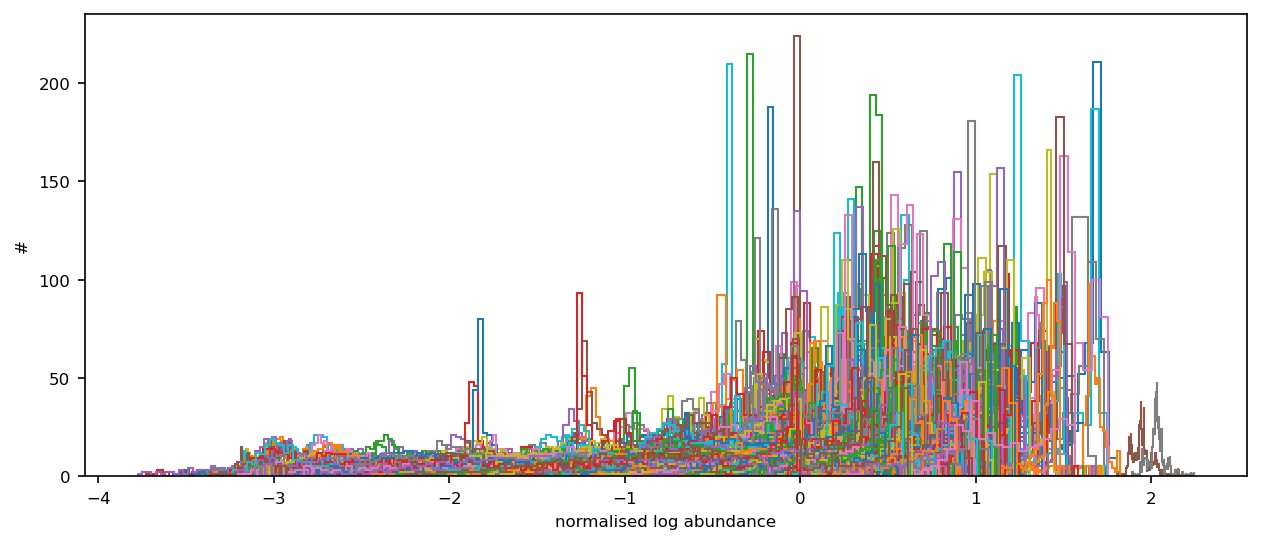

In [17]:
pl.plot_hist(x_test_hat)

## Comparison of abundance profile

In [14]:
dir_test = '/lhome/silkem/MACE/MACE/test_data/'

In [15]:
rad, real, pred = tr.test_abundance_profile(dir_test, 'test', model, DEVICE, kwargs, scale = 'norm')

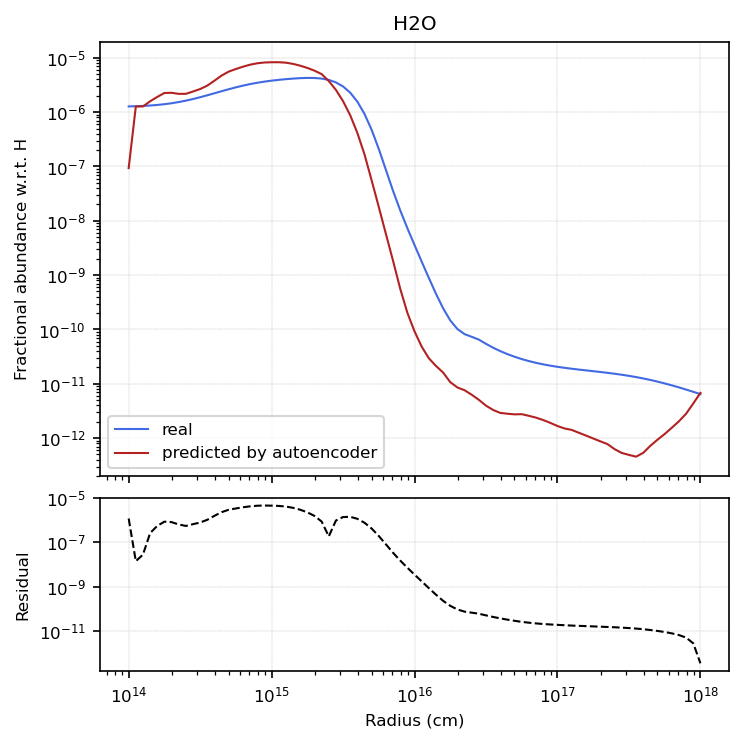

In [16]:
pl.plot_fracs_profile(rad, real, pred, molecs, 'H2O')